In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *


from BaselinePrerocess import baseline_process
from cnn import CNN

import pygad
import time

### Preprocess

In [2]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9

In [3]:
train_X_mask, val_X_mask, test_X_mask, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler = baseline_process(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


In [4]:
print(train_X_mask.shape, val_X_mask.shape, test_X_mask.shape, train_ws_y.shape, val_ws_y.shape, test_ws_y.shape)

(77069, 96, 16) (9634, 96, 16) (19268, 96, 16) (77069, 96) (9634, 96) (19268, 96)


### Select event

In [5]:
start_idx = 16700
end_idx = 17000
duration = end_idx - start_idx

In [6]:
ws1 = test_ws_y[start_idx:end_idx, :]
ws1 = ws_scaler.inverse_transform(ws1)
ws1.shape

(300, 96)

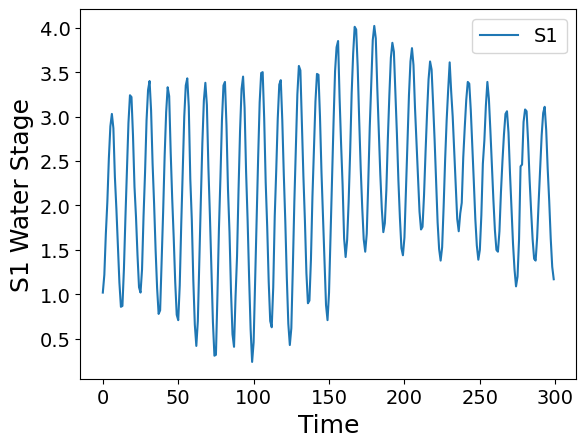

In [7]:
plt.plot(ws1[:, 0], label='S1')
plt.xlabel('Time', fontsize=18)
plt.ylabel('S1 Water Stage', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

### Get optimizable and not optimizable variables

In [8]:
X = test_X_mask[start_idx:end_idx, :, :]
X_1d = np.reshape(X, -1)

print(X.shape)
print(X_1d.shape)

(300, 96, 16)
(460800,)


In [9]:
gate_state = test_X_mask[start_idx:end_idx, :, 2:9]
gate_state_1d = np.reshape(gate_state, -1)

print(gate_state.shape)
print(gate_state_1d.shape)

(300, 96, 7)
(201600,)


In [10]:
not_gate1 = test_X_mask[start_idx:end_idx, :, 0:2]

print(not_gate1.shape)

(300, 96, 2)


In [11]:
not_gate2 = test_X_mask[start_idx:end_idx, :, 9:]

print(not_gate2.shape)

(300, 96, 7)


### GA

In [12]:
saved_model = load_model('cnn.h5', compile=False)

In [13]:
def fitness_func(ga_instance, solution, solution_idx):
    # reshape gate to 3d
    solution = np.reshape(solution, (duration, 96, 7))
    
    # get input numpy
    input_np = np.zeros(((duration, 96, 16)))
    input_np[:, :, 0:2] = not_gate1
    input_np[:, :, 2:9] = solution
    input_np[:, :, 9:] = not_gate2
    
    yhat = saved_model.predict(input_np, verbose=0)
    
    y_max = 0.62
    y_min = 0.2
    
    penalty_sum = 0
    for i in range (duration):
        for j in range (96):
            if (yhat[i, j] > y_max):
                penalty = np.abs(yhat[i, j] - y_max) + 20*np.abs(yhat[i, j] - y_max)**2
            elif (yhat[i, j] < y_min):
                penalty = np.abs(y_min - yhat[i, j])
                
            else:
                penalty = 0
            
            penalty_sum += penalty
    
    
    if penalty_sum == 0:
        fitness = 9999999999999
    else:
        fitness = 1.0 / penalty_sum
    return fitness

In [14]:
fitness_function = fitness_func

num_generations = 200
num_parents_mating = 8

sol_per_pop = 64
num_genes = len(gate_state_1d)

init_range_low = 0
init_range_high = 1

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 5

In [15]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_space = {'low': 0, 'high': 1})

In [16]:
start_time = time.perf_counter()
ga_instance.run()
cpu_time = time.perf_counter() - start_time
print(f"CPU time: {cpu_time} seconds")

CPU time: 2772.5704114 seconds


In [17]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

Parameters of the best solution : [0.11906507 0.3584901  0.44088038 ... 0.41892665 0.86154861 0.54156512]
Fitness value of the best solution = 0.00010322851806225588


### Post-processing

In [18]:
best_gate = np.reshape(solution, (duration, 96, 7))

best_input = np.zeros(((duration, 96, 16)))
best_input[:, :, 0:2] = not_gate1
best_input[:, :, 2:9] = best_gate
best_input[:, :, 9:] = not_gate2

best_perf = saved_model.predict(best_input)
best_perf = ws_scaler.inverse_transform(best_perf)

10/10 [==============================] - 0s 1ms/step


In [19]:
count = 0

for i in range (duration):
    for j in range (96):
        if best_perf[i, j] > 3.5:
            count += 1

print(count)

448


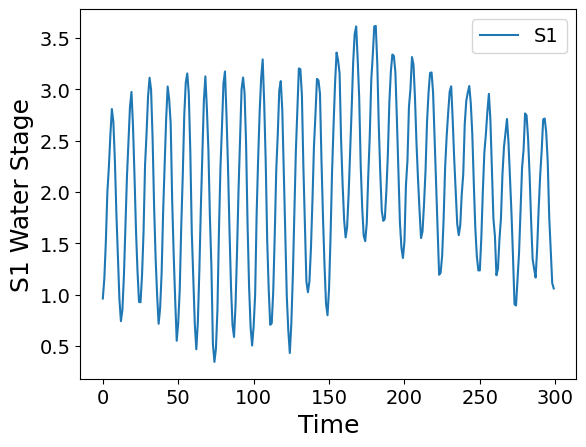

In [20]:
plt.plot(best_perf[:, 0], label='S1')
plt.xlabel('Time', fontsize=18)
plt.ylabel('S1 Water Stage', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [21]:
Optimal_gate = pd.DataFrame(best_gate.reshape(duration, -1) )
Optimal_gate.to_csv("GA results/best_gate_event4.csv", index=False)
Optimal_gate

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,668,669,670,671
0,0.119065,0.358490,0.440880,0.988358,0.688627,0.532398,0.044466,0.326668,0.772922,0.917809,...,0.406369,0.020741,0.586719,0.341633,0.989441,0.905292,0.889163,0.060988,0.173440,0.242346
1,0.333945,0.596208,0.028123,0.174862,0.801003,0.932450,0.270113,0.359382,0.584999,0.701871,...,0.884883,0.662948,0.679508,0.562417,0.402767,0.075013,0.690099,0.474558,0.797560,0.456339
2,0.701627,0.620301,0.782175,0.779425,0.497170,0.843254,0.413060,0.481189,0.772118,0.993543,...,0.427707,0.102584,0.496087,0.442811,0.255780,0.412912,0.537552,0.066139,0.564848,0.876497
3,0.399470,0.812684,0.891155,0.463824,0.472714,0.990080,0.873301,0.554614,0.353664,0.379822,...,0.232598,0.497657,0.332748,0.015116,0.545698,0.137618,0.512819,0.156181,0.780736,0.657467
4,0.617894,0.942809,0.766376,0.324785,0.315669,0.709150,0.282323,0.421280,0.858645,0.860913,...,0.458934,0.940392,0.368361,0.564990,0.033915,0.655682,0.961836,0.567923,0.612797,0.671516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.250896,0.055293,0.931023,0.742330,0.096417,0.713771,0.375792,0.604547,0.857932,0.224677,...,0.842883,0.025390,0.848972,0.568742,0.428449,0.822573,0.211563,0.778460,0.838660,0.009935
296,0.527503,0.241014,0.709246,0.902727,0.439969,0.186345,0.256100,0.088349,0.355642,0.696691,...,0.957103,0.348574,0.841095,0.698666,0.309193,0.534642,0.307141,0.550003,0.458673,0.847217
297,0.436069,0.570126,0.940997,0.284558,0.749398,0.270300,0.566812,0.112088,0.524041,0.304842,...,0.650156,0.244392,0.838599,0.905916,0.770782,0.978506,0.496517,0.584549,0.320010,0.255859
298,0.360243,0.537243,0.779378,0.595113,0.745035,0.429330,0.824309,0.013408,0.266725,0.444409,...,0.043456,0.404310,0.232415,0.571443,0.236398,0.072930,0.189061,0.010895,0.627672,0.763212


In [22]:
Optimal_case = pd.DataFrame(best_perf)
Optimal_case.to_csv("GA results/best_performance_event4.csv", index=False)
Optimal_case

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,0.961650,1.081944,1.220313,1.294779,1.167142,1.255164,1.317624,1.435479,1.552832,1.682981,...,2.590798,2.845568,2.044003,2.371300,2.268403,2.419515,1.672737,2.054473,1.951290,2.066777
1,1.156639,1.251784,1.318193,1.376682,1.554492,1.643797,1.647374,1.759931,1.933424,2.003624,...,2.060256,2.246093,1.402023,1.675926,1.639374,1.767528,1.077565,1.313331,1.323465,1.421496
2,1.510147,1.515448,1.611965,1.729928,2.007493,1.929956,2.030527,2.220222,2.252242,2.212950,...,1.733651,1.889766,1.238482,1.362427,1.470024,1.583602,1.118914,1.173273,1.325205,1.408816
3,1.995027,2.039293,2.083466,2.160965,2.465965,2.485701,2.506589,2.634558,2.718804,2.796492,...,1.508013,1.538291,1.117182,1.246852,1.413656,1.396594,1.254013,1.308542,1.455569,1.492033
4,2.237963,2.370712,2.302425,2.336573,2.658277,2.700648,2.656361,2.759588,2.756042,2.819668,...,1.383578,1.410991,1.173064,1.313591,1.379070,1.461073,1.447143,1.559583,1.568190,1.723825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,2.298625,2.476865,2.353263,2.655728,2.021951,2.241938,2.155045,2.313146,1.683290,2.017272,...,2.601719,3.028069,2.832734,3.120665,2.745641,3.257442,2.752455,2.978059,2.711429,3.210370
296,1.757149,1.982439,1.914563,2.133395,1.405698,1.683274,1.646058,1.725328,1.091278,1.458464,...,2.760974,3.173047,2.856461,3.076234,2.820776,3.280467,2.645680,2.802754,2.630591,3.080079
297,1.424502,1.657151,1.589314,1.772828,1.212479,1.526153,1.423544,1.438946,1.081458,1.413751,...,2.726346,3.213589,2.659477,2.858910,2.611851,3.130026,2.374031,2.652843,2.374442,2.844251
298,1.111144,1.371077,1.383215,1.467172,1.029603,1.378811,1.297551,1.292796,1.119195,1.469671,...,2.759803,3.126210,2.480395,2.621883,2.536473,2.857764,2.190163,2.409105,2.317379,2.623379
